In [1]:
import torch
import torchvision
import PIL
import os
from matplotlib import pyplot as plt
import cv2
import random
import warnings
import timm
from torch import nn
import numpy as np
from tqdm import tqdm_notebook
from torchvision.models import mobilenet_v3_small
from torchsummary import summary
import glob

import seaborn as sb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')


Using: cuda


In [2]:
model=mobilenet_v3_small(weights='DEFAULT')
model.classifier[3]=nn.Linear(in_features=1024,out_features=2,bias=True)

In [3]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src=None,paths=None):
        if src is not None:
            self.src=src
            self.images=os.listdir(src)
            
        else:
            self.src=None
            self.images=paths

        self.CropIt=torchvision.transforms.CenterCrop((1920,1080))

        self.transforms=torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                       torchvision.transforms.CenterCrop((224,224))])
    
    def __len__(self):
        return len(self.images)


    def random_float(self,min_val, max_val, decimal_places):
        return round(random.uniform(min_val, max_val), decimal_places)


    def __getitem__(self,idx):
        if self.src is not None:
            img=cv2.imread(self.src+"/"+self.images[idx])
        else:
            img=cv2.imread(self.images[idx])

        height, width = img.shape[:2]

        x = (width - 1920) // 2
        y = (height - 1080) // 2
        
        img = img[y:y+1080, x:x+1920]

        #print(img.shape)
          
        pixelize=random.randint(0,1)

        
        #t_lower = 130  # Lower Threshold 
        #t_upper = 200  # Upper threshold 

        t_lower = 50  # Lower Threshold 
        t_upper = 150  # Upper threshold 
        
        downsize=random.randint(0,1)

        if(downsize):
            image=img
            
            original_height, original_width = image.shape[:2]

            scale_factor =  self.random_float(1.5, 4, 2)


            new_width = int(original_width // scale_factor)
            new_height = int(original_height // scale_factor)  
            
            downscaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
            
            upscaled_image = cv2.resize(downscaled_image, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

            upscaled_image=torch.from_numpy(cv2.Canny(upscaled_image,t_lower,t_upper)[np.newaxis,...])

            upscaled_image=torch.vstack((upscaled_image,upscaled_image,upscaled_image))
            return self.transforms(upscaled_image.type(torch.float32)), torch.tensor([0,1]).type(torch.float32)
                            
        else:
            
            img = torch.from_numpy(cv2.Canny(img,t_lower,t_upper)[np.newaxis,...])
            img = torch.vstack((img,img,img))
            
            return self.transforms(img.type(torch.float32)),torch.tensor([1,0]).type(torch.float32)
        

In [4]:
test_ds=dataset('../../../DIV2K/')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([0., 1.])


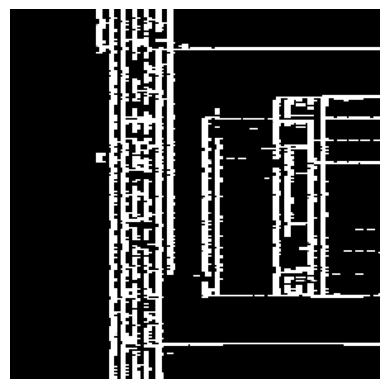

In [5]:
plt.axis(False)
t=test_ds.__getitem__(torch.randint(0,1000,(1,)))
print(t[0].shape)
plt.imshow(t[0].permute(1,2,0))
print(t[1])

In [6]:
test_loader=torch.utils.data.DataLoader(test_ds,16,shuffle=True)

In [7]:
loss_fn=nn.CrossEntropyLoss()
model=model.to(device)

In [8]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)


In [9]:
def test_model(model):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.CrossEntropyLoss()
    
    test_preds=torch.tensor([])
    test_actual=torch.tensor([])

    
    predictions=[]
    targets=[]
    
    temp_test_accuracy=[]
    temp_test_loss=[]

    net_test_accuracy=0
    net_test_loss=0

    #Evaluation
    print("Testing:")
    model.eval()

    

    with tqdm_notebook(total=len(test_loader)) as pbar2:
        for x,y in test_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                
                #Track of metrics
                preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                accuracy_test=accuracy_fn(logits,torch.argmax(y,dim=1))
                temp_test_accuracy.append(accuracy_test)
                temp_test_loss.append(loss.item())
                predictions.extend(torch.argmax(torch.softmax(logits,dim=1),dim=1).tolist())
                targets.extend(torch.argmax(y, dim=1).tolist())

                #Progress Bar Update
                pbar2.update(1)
                
                
        pbar2.close()

    

    conf_matrix = confusion_matrix(targets, predictions)

    # Calculate precision, recall, and F1 score
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    
    print("Confusion Matrix:")
    print("\nPrecision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    
    net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
    net_test_loss=sum(temp_test_loss)/len(temp_test_loss)

    print(f"Test Accuracy: {net_test_accuracy}\nTest Loss: {net_test_loss}")

    plt.figure(figsize=(10, 7))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pixelated'], yticklabels=['Normal', 'Pixelated'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Testing:


  0%|          | 0/57 [00:00<?, ?it/s]

Confusion Matrix:

Precision: 0.8752886836027713
Recall: 0.8875878220140515
F1 Score: 0.8813953488372092
Test Accuracy: 0.8881578947368421
Test Loss: 0.3331673649678889


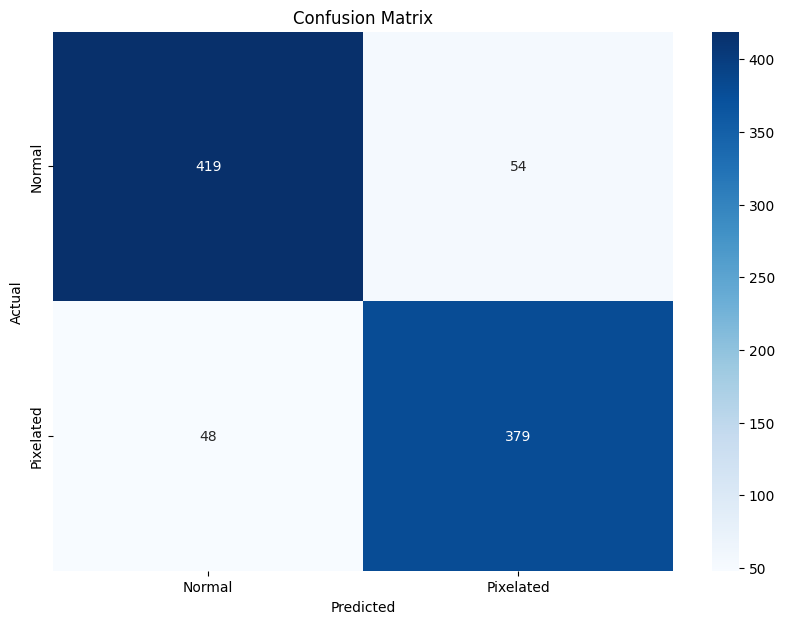

In [12]:
model.load_state_dict(torch.load('./method2(0.960).pt'))
test_model(model)